# Actividad 2

# Controlador en esquema de Espacio de estados.

El objetivo de este trabajo es realizar un controlador pero en este caso partiendo de la base de un esquema de ESPACIO DE ESTADOS.

## Caso 1 - Motor CC

Partiendo de las ecuaciones de motor y parametros calculados en el trabajo practico anterior

$   LAA=7.14e-04 ;
    J=3.1210e-06; 
    Ra=27; 
    B=0; 
    Ki=16.5 
    Km= 0.0606
$


Modelado por las siguientes Ecuaciones diferenciales:

$\frac{di_a}{dt}=\frac{R_A}{L_{AA}}ia-\frac{K_m}{L_{AA}}\omega _r+\frac{1}{L_{AA}}Va $

$ \frac{d\omega_r}{dt}=\frac{K_i}{J}ia-\frac{B_m}{J}\omega _r+\frac{1}{J}T_L $

$ \frac{d\theta _t}{dt}=\omega _r $


Podiamos modelar un controlador PID obteniendo sus constantes como : Ki=0.01 ;  Kp0.5 ; Kd=1


### Espacio de estados

In [1]:
# Importacion de librerias

import numpy as np
import control as ct
import math
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *
import cmath as cm
from math import log
import sympy as sp
from scipy import signal


A partir de las ecuaciones diferenciales modelamos en espacio de estados. Reescribiendo las ecuaciones en matrices y llevando a espacio de estados

In [2]:
# Definir los parámetros del sistema
R_A =27
L_AA =4.97e-4
K_m = 0.0606
J = 2.5518e-9
B_m = 0
K_i = 0.0102

## Definir las matrices del sistema de espacio de estados
A = np.array([[-R_A / L_AA, -K_m / L_AA, 0],
              [K_i / J, -B_m / J, 0],
              [0, 1, 0]])

B = np.array([[1 / L_AA],
              [0],
              [0]])

C = np.array([[0, 0, 1]])

D = np.array([[0]])
#print('A:', A)
#print('B:', B)
#print('C:', C)
#print('D:', D)


# Crear el sistema de espacio de estados
#sys= ss(A, B, C, D)
sys = signal.StateSpace(A, B, C,D)
tf = signal.StateSpace.to_tf(sys)
print("Función de transferencia:")
print(tf)
#sys_tf=ct.ss2tf(sys)
#print('sys_tf:', sys_tf)

# Función de transferencia



Función de transferencia:
TransferFunctionContinuous(
array([-3.63797881e-11, -4.76837158e-07,  8.04261260e+09]),
array([1.00000000e+00, 5.43259557e+04, 4.87382324e+08, 0.00000000e+00]),
dt: None
)


/home/mateo_d/.local/lib/python3.10/site-packages/scipy/signal/_ltisys.py:600: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


In [3]:
# Función de transferencia
num = [-3.63797881e-11, -4.76837158e-07, 8.04261260e+09]
den = [1.00000000e+00, 5.43259557e+04, 4.87382324e+08, 0.00000000e+00]

# Redondear cada coeficiente
rounded_num = [round(coeff, 2) for coeff in num]
rounded_den = [round(coeff, 2) for coeff in den]

# Mostrar los coeficientes redondeados
print("Numerador redondeado:", rounded_num)
print("Denominador redondeado:", rounded_den)

Numerador redondeado: [-0.0, -0.0, 8042612600.0]
Denominador redondeado: [1.0, 54325.96, 487382324.0, 0.0]


## Obvservabilidad

Determino si el sistema es observable. Debo construir la matriz de obvservabilidad. La cual es la siguiente:

$\begin{bmatrix}
C\\
CA 
\\
CA^{n-1} 
\end{bmatrix}$

Calculo su rango , si el rango de es igual al numero de estados de el sisema , entonces el sistema es obvservable

In [4]:
n = A.shape[0] #numero de estados
O = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n)])
print('Matriz de observabilidad:\n', O)
range_O = np.linalg.matrix_rank(O)
print('Rango de la matriz de observabilidad:', range_O)
# Verificar observabilidad
if range_O == n:
    print("El sistema es completamente observable.")
else:
    print("El sistema no es completamente observable.")


Matriz de observabilidad:
 [[0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [3.99717846e+06 0.00000000e+00 0.00000000e+00]]
Rango de la matriz de observabilidad: 3
El sistema es completamente observable.


## Controlabilidad
Determino si el sistema es observable. Debo construir la matriz de obvservabilidad. La cual es la siguiente:

$\begin{bmatrix}
A &AB  &A^{n-1}B 
\end{bmatrix}$

Calculo su rango , si el rango de es igual al numero de estados de el sisema , entonces el sistema es controlable


In [5]:
# Calcular la matriz de controlabilidad
n = A.shape[0]  # Número de estados
C_ctrl = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])

print('Matriz de controlabilidad:\n', C_ctrl)
range_C_ctrl = np.linalg.matrix_rank(C_ctrl)
print('Rango de la matriz de controlabilidad:', range_C_ctrl)

# Verificar controlabilidad
if range_C_ctrl == n:
    print("El sistema es completamente controlable.")
else:
    print("El sistema no es completamente controlable.")


Matriz de controlabilidad:
 [[ 2.01207243e+03 -1.09307758e+08  4.95759989e+12]
 [ 0.00000000e+00  8.04261260e+09 -4.36922616e+14]
 [ 0.00000000e+00  0.00000000e+00  8.04261260e+09]]
Rango de la matriz de controlabilidad: 3
El sistema es completamente controlable.


## Tiempo de simulacion e integración

In [6]:
# Definir el tiempo de simulación y tiempo de integración
#Tiempo de integracion de euler -> obtener polos lazo abierto

poles= np.linalg.eigvals(A)
print('Polos:', poles)

#El polo mayor es 0 pero no es parte de la dinamica de el sistema(indica no estabilidad)
dominant_complex_pole = poles[1]  # Se elige uno de los polos complejos conjugados

#Tiempo intrgracion de euler
tR = np.log(0.95) / np.abs(dominant_complex_pole.real)
print('Tiempo de integración de Euler:', tR)

#Tiempo de simulacion

Polos: [     0.         -11337.52232726 -42988.43340714]
Tiempo de integración de Euler: -4.524206692339342e-06


## Asignacion de polos

Habiendo obtenido la funcion de transferencia del sistema

$G(s) = \frac{s^2 - 2.77708750 \times 10^{-7}s + 4.57875458 \times 10^6}{1.00000000s^3 + 3.78151261 \times 10^4s^2 + 2.77472527 \times 10^5s + 2.18278728 \times 10^{-11}}$

Coincide el orden del numerador con la cantidad de estados

In [7]:
# Calcular los polos del sistema abierto
poles_LA= np.linalg.eigvals(A)
print("Polos del sistema abierto:", poles_LA)  
## Polos del sistema abierto -> (0,-7.339,-3.78e+4)


#Forma canonica controlable

#Aplico Ackermann

# Convertir el sistema a su forma controlable
T = ct.ctrb(A, B)
T_inv = np.linalg.inv(T)
Ac = T_inv @ A @ T
Bc = T_inv @ B

# Especificar los polos deseados
polos_deseados = [-1.5, -2, -20000]

# Calcular las ganancias del controlador utilizando el método de Ackermann
K = ct.acker(Ac, Bc, polos_deseados)

print("Ganancias del controlador (Ackermann):")
print(K)



Polos del sistema abierto: [     0.         -11337.52232726 -42988.43340714]
Ganancias del controlador (Ackermann):
[[-3.43224557e+04  1.37728789e+09 -5.80943227e+13]]


## LQR

In [8]:
#implementacion controlador LQR

#NO FUNCIONA VERSION DE SLYCOT, en collab funciona y obtuve K


#implementacion controlador LQR
# Definir las matrices de ponderación Q y R
#Q = np.diag([0.44, 2.5e-5, 6.25, 100000]) # Ponderaciones de estado
#R = np.array([100])                  # Ponderaciones de entrada

# Ampliar las matrices A y B para incluir un integrador adicional
#A_ampliada = np.vstack([np.hstack([A, np.zeros((A.shape[0], 1))]), np.hstack([-C, np.zeros((1, 1))])])
#B_ampliada = np.vstack([B, np.zeros((1, B.shape[1]))])

#print("A_ampliada:")
#print(A_ampliada)

#print("B_ampliada:")
#print(B_ampliada)

# Calcular el controlador LQR
#K, _, _ = ct.lqr(A_ampliada, B_ampliada, Q, R)

#print("Ganancia del controlador K:")
#print(K)


# Imprimir las dimensiones de las matrices ampliadas
#print("Dimensiones de A_ampliada:", A_ampliada.shape)
#print("Dimensiones de B_ampliada:", B_ampliada.shape)



#NO FUNCIONA VERSION DE SLYCOT, en collab funciona y obtuve K



## Referencia y torque

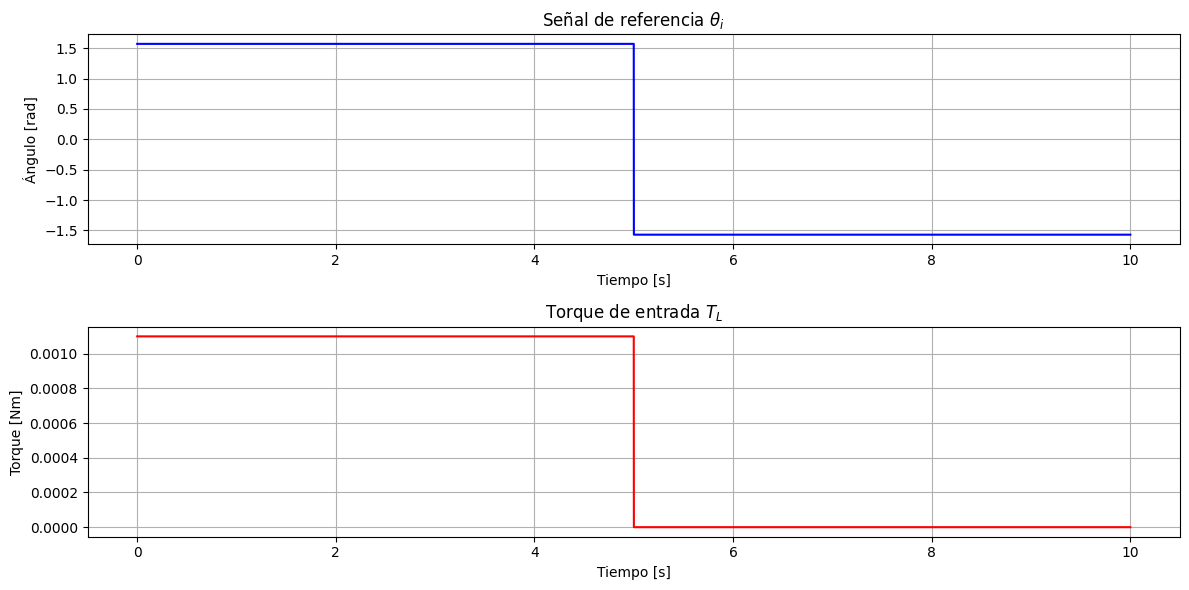

In [9]:
# Definir el tiempo de simulación
h = 1e-4
tSim = 10
t = np.arange(0, tSim, h)

# Frecuencia de señal
frequency = 0.1  # Frecuencia de la señal en Hz (cada 10 segundos)

# Definir la señal de referencia
reference = np.pi/2 * signal.square(2 * np.pi * frequency * t, duty=0.5)

# Definir el torque de entrada
torque = ((1.1e-3) / 2) * signal.square(2 * np.pi * frequency * t, duty=0.5) + ((1.1e-3) / 2)

# Graficar la señal de referencia
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, reference, 'b', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.title('Señal de referencia $\\theta_i$')
plt.grid(True)

# Graficar el torque de entrada
plt.subplot(2, 1, 2)
plt.plot(t, torque, 'r', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Torque [Nm]')
plt.title('Torque de entrada $T_L$')
plt.grid(True)

plt.tight_layout()
plt.show()

## Simulacion


/tmp/ipykernel_8169/2350940159.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stateVector[3] += zetaP * h  # Actualizar el estado del integrador


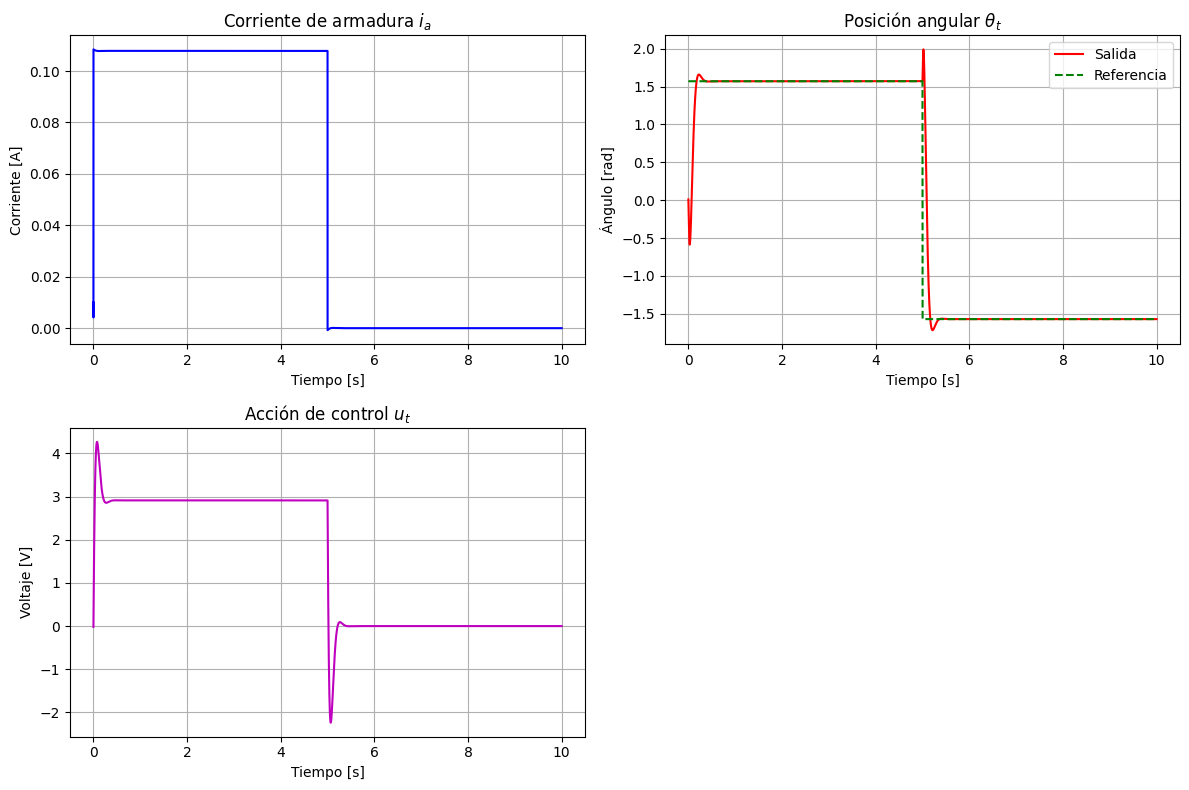

In [10]:
# Ganancia del controlador K
K = np.array([[1.64188560e-02, 2.22110346e-04, 1.97717678e+00, -3.16227766e+01]])

# Definir el tiempo de simulación
h = 1e-5
tSim = 10
t = np.arange(0, tSim, h)

# Frecuencia de señal
frequency = 0.1  # Frecuencia de la señal en Hz (cada 10 segundos)

# Definir la señal de referencia
reference = np.pi/2 * signal.square(2 * np.pi * frequency * t, duty=0.5)

# Definir el torque de entrada
torque = ((1.1e-3) / 2) * signal.square(2 * np.pi * frequency * t, duty=0.5) + ((1.1e-3) / 2)

# Condiciones iniciales nulas
x = np.array([0.01, 0.01, 0.01, 0])  # Inicializa ia, w, tita, zeta con valores nulos
stateVector = x.copy()             # Asegurar que stateVector coincide con x


# Inicializar las variables de estado
ia = np.zeros(len(t))
w = np.zeros(len(t))
tita = np.zeros(len(t))
u = np.zeros(len(t))
psi = np.zeros(len(t))

# Simulación
for i in range(len(t)):
    zetaP = reference[i] - np.dot(C, stateVector[:3])
    stateVector[3] += zetaP * h  # Actualizar el estado del integrador
    u[i] = -np.dot(K[0, :3], stateVector[:3]) - K[0, 3] * stateVector[3]  # Corrección en el cálculo de u
    ia[i] = stateVector[0]
    w[i] = stateVector[1]
    tita[i] = stateVector[2]
    
    x1P = (-R_A * stateVector[0] - K_m * stateVector[1] + u[i]) / L_AA
    x2P = (K_i * stateVector[0] - B_m * stateVector[1] - torque[i]) / J
    x3P = stateVector[1]
    
    stateVector[:3] += h * np.array([x1P, x2P, x3P])  # Actualizar el vector de estado

    # Limitar la acción de control
    if u[i] > 24:
        u[i] = 24
    elif u[i] < -24:
        u[i] = -24

# Graficar resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t, ia, 'b', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Corriente [A]')
plt.title('Corriente de armadura $i_a$')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t, tita, 'r', linewidth=1.5)
plt.plot(t, reference, 'g--', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.title('Posición angular $\\theta_t$')
plt.legend(['Salida', 'Referencia'])
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t, u, 'm', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Acción de control $u_t$')
plt.grid(True)

plt.tight_layout()
plt.show()

# Observador

Se pide un observador para el caso que solo pueda medirse ángulo de salida. El objetivo de el uso del observador es medir la corriente, ya que solo tenemos acceso al angulo. Para el calculo del LQR, las matrices difieren de la siguiente manera.
Tener en cuenta que ahora tenemos dos variables a observar , entonces la matriz C va a cambiar a dos filas con un 1 en la variable de interes

In [11]:
# Definir los parámetros del sistema
#R_A =27
#L_AA =4.97e-4
#K_m = 0.0606
#J = 2.5518e-9
#B_m = 0
#K_i = 0.0102

# Definir las matrices del sistema de espacio de estados
#A = np.array([[-R_A / L_AA, -K_m / L_AA, 0],
#              [K_i / J, -B_m / J, 0],
#              [0, 1, 0]])

#B = np.array([[1 / L_AA],
#             [0],
#             [0]])

# Definir la matriz C
#C = np.array([[0, 0, 1],   # Medición del ángulo
#              [0, 1, 0]])  # Medición de la velocidad

# Transponer las matrices 
#Ao = np.transpose(A)
#Bo = np.transpose(C)
#Co = np.transpose(B)
#print(Ao)
#print(Bo)
#print(Co)

#Qo = np.diag([1, 1, 1])
#Ro = np.diag([1,1])
#print(Qo)
#print(Ro)
# Calcular el controlador LQR Ko
#Ko, _, _ = ct.lqr(Ao,Bo, Qo, Ro)

# Mostrar el resultado
#print("Controlador LQR Ko:")
#print(Ko)

## CONTROLADOR CALCULADO EN COLLAB DEBIDO A PROBLEMA DE SLYCOT



In [12]:
Ko = np.array([[-7.54774664e-08, 3.36287608e-05, 3.16334090e-01],
               [-1.12159565e-09, 3.01717687e-01, 3.36287608e-05]])


# Definir parámetros de simulación
h = 1e-5  # Paso de integración
sim_time = 10  # Tiempo de simulación en segundos
t = np.arange(0, sim_time, h)
steps = len(t)

# Frecuencia de la señal
frequency = 0.1  # Frecuencia de la señal en Hz (cada 10 segundos)

# Definir la señal de referencia
reference = (np.pi / 2) * signal.square(2 * np.pi * frequency * t, duty=0.5)

# Definir el torque de entrada
torque = ((1.1e-3) / 2) * signal.square(2 * np.pi * frequency * t, duty=0.5) + ((1.1e-3) / 2)

# Estado inicial del observador y del sistema
obs_state_vector = np.array([0, 0, 0], dtype=float)
state_vector = np.array([0, 0, 0], dtype=float)
integ = 0.0

#x = np.zeros(4)  # Inicializa ia, w, tita, zeta con valores nulos
#stateVector = x.copy()  # Asegurar que stateVector coincide con x


# Variables de almacenamiento
ia = np.zeros(steps)
omega = np.zeros(steps)
theta = np.zeros(steps)
iaO = np.zeros(steps)
omegaO = np.zeros(steps)
thetaO = np.zeros(steps)
zeta = np.zeros(steps)
u = np.zeros(steps)

# Simulación
for i in range(steps):
    # Controlador basado en el estado observado
    zetaP = reference[i] - np.dot(Ko, obs_state_vector)  # Se utiliza Ko.T para multiplicación correcta
    u[i] = -np.dot(Ko.T, obs_state_vector) - zeta[i]
    
    # Actualización del estado real
    ia[i] = state_vector[0]
    omega[i] = state_vector[1]
    theta[i] = state_vector[2]
    
    x1P = -R_A * state_vector[0] / L_AA - K_m * state_vector[1] / L_AA + u[i] / L_AA
    x2P = K_i * state_vector[0] / J - B_m * state_vector[1] / J - torque[i] / J
    x3P = state_vector[1]
    xP = np.array([x1P, x2P, x3P])
    
    state_vector = state_vector + xP * h
    
    # Actualización del estado observado
    iaO[i] = obs_state_vector[0]
    omegaO[i] = obs_state_vector[1]
    thetaO[i] = obs_state_vector[2]
    
    yO = np.dot(C, obs_state_vector)
    y = np.dot(C, state_vector)
    
    xTP = np.dot(A, obs_state_vector) + B.flatten() * u[i] + np.dot(Ko.T, (y - yO))  # Ko.T para multiplicación correcta
    obs_state_vector = obs_state_vector + xTP * h
    
    zeta[i] = integ + zetaP * h  # Calcular zeta después de actualizar el estado observado
    integ = zeta[i]

# Gráficas de resultados
plt.figure()
plt.plot(t, iaO, label='Corriente Observada')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Corriente [A]')
plt.title('Corriente de armadura i_a observada')
plt.grid(True)
plt.legend()
plt.show()

ValueError: shapes (3,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

In [ ]:
## Hamiltoniano

# Definir los parámetros del sistema
from matplotlib.pylab import eig


R_A =27
L_AA =4.97e-4
K_m = 0.0606
J = 2.5518e-9
B_m = 0
K_i = 0.0102

# Definir las matrices del sistema de espacio de estados
A = np.array([[-R_A / L_AA, -K_m / L_AA, 0],
              [K_i / J, -B_m / J, 0],
              [0, 1, 0]])

B = np.array([[1 / L_AA],
             [0],
             [0]])

# Definir la matriz C
C = np.array([[0, 0, 1],   # Medición del ángulo
              [0, 1, 0]])  # Medición de la velocidad

# Transponer las matrices 
Ao = np.transpose(A)
Bo = np.transpose(C)

Qo = np.diag([100, 10, 1])
Ro = np.diag([1,1])


#Mat_Har=np.block([[Mat_A_O, -np.matmul(Mat_B_O, np.matmul(np.linalg.inv(Rdual),np.transpose(Mat_B_O)))]])
#Mat_Hab=np.block([[-Qdual, -np.transpose(Mat_A_O)]])
#Mat_H=np.block([[Mat_Har],[Mat_Hab]])

Mat_Har=np.block([[Ao, -np.matmul(Bo, np.matmul(np.linalg.inv(Ro),np.transpose(Bo)))]])
Mat_Hab=np.block([[-Qo, -np.transpose(Ao)]])
Mat_H=np.block([[Mat_Har],[Mat_Hab]])

D, V = eig(Mat_H)
MX1X2 = np.zeros((6, 3), dtype=complex)
jj = 0
for ii in range(6):
    if np.real(D[ii]) < 0:
        MX1X2[:, jj] = V[:, ii]
        jj += 1

# Corregir la extracción de MX1 y MX2
MX1 = MX1X2[:3, :]
MX2 = MX1X2[3:, :]
P = np.real(np.matmul(MX2, np.linalg.inv(MX1)))
ko = np.matmul(np.matmul(np.linalg.inv(Ro), np.transpose(Bo)), P)
Ko = np.transpose(ko)

print('Ko:', Ko)
print('Polos del Observador:')
auto_val_LCO,auto_vect_LCO=eig(A-Ko@C)
auto_val_LCO

Ko: [[-7.50762858e-06  1.12181593e-04]
 [ 3.34596177e-03  3.01134468e+01]
 [ 1.00333480e+00  3.34596177e-03]]
Polos del Observador:


array([-4.29776185e+04, -1.13784507e+04, -1.00333511e+00])

In [ ]:
# Definir el tiempo de simulación
h = 1e-5
tSim = 10
t = np.arange(0, tSim, h)

# Frecuencia de señal
frequency = 0.1  # Frecuencia de la señal en Hz (cada 10 segundos)

# Definir la señal de referencia
reference = np.pi/2 * signal.square(2 * np.pi * frequency * t, duty=0.5)

# Definir el torque de entrada
torque = ((1.1e-3) / 2) * signal.square(2 * np.pi * frequency * t, duty=0.5) + ((1.1e-3) / 2)

# Condiciones iniciales no nulas
x = np.array([0.0, 0.0, 0.0])  # Inicializa ia, w, tita, zeta con valores no nulos
stateVector = x.copy()            # Asegurar que stateVector coincide con x

# Inicializar las variables de estado
ia = np.zeros(len(t))
w = np.zeros(len(t))
tita = np.zeros(len(t))
u = np.zeros(len(t))
psi = np.zeros(len(t))

# Simulación
for i in range(len(t)):
    zetaP = reference[i] - np.dot(C, stateVector[:3])
    psi[i] = np.dot(Ko[:, :3], stateVector[:3][:, np.newaxis]).flatten()

    stateVector[3] += zetaP * h  # Actualizar el estado del integrador
    u[i] = -psi[i]  # Controlador utilizando la estimación del estado
    ia[i] = stateVector[0]
    w[i] = stateVector[1]
    tita[i] = stateVector[2]

    x1P = (-R_A * stateVector[0] - K_m * stateVector[1] + u[i]) / L_AA
    x2P = (K_i * stateVector[0] - B_m * stateVector[1] - torque[i]) / J
    x3P = stateVector[1]

    stateVector[:3] += h * np.array([x1P, x2P, x3P])  # Actualizar el vector de estado

    # Limitar la acción de control
    if u[i] > 24:
        u[i] = 24
   
# Graficar resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t, ia, 'b', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Corriente [A]')
plt.title('Corriente de armadura $i_a$')
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: shapes (3,2) and (3,1) not aligned: 2 (dim 1) != 3 (dim 0)